Mount

In [ ]:
# Import images from google drive

#connect to google drive - mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


imports

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil
from tqdm import tqdm

# **Classify when each mandarin is 1 instance**

split data to train valid test

In [ ]:
# Paths
csv_path = "/content/gdrive/Othercomputers/My PC/Thesis/2023_Tags_.csv"
image_dir = "/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB"

# Load CSV
data = pd.read_csv(csv_path)

# Add image paths to the dataframe
data['image_path'] = data['id'].apply(lambda x: os.path.join(image_dir, f"{x}.JPG"))
data['exists'] = data['image_path'].apply(lambda x: os.path.exists(x))

# Filter only existing files
data = data[data['exists']]

# Split data (70% train, 20% validation, 10% test)
train_val_data, test_data = train_test_split(data, test_size=0.1, stratify=data['tag'], random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, stratify=train_val_data['tag'], random_state=42)

# Create folders for splits
output_dir = "/content/dataset"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

# Create directories if they don't exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Helper function to copy files
def copy_files(data, dest_dir):
    for _, row in tqdm(data.iterrows(), total=len(data)):
        src_path = row['image_path']
        dest_path = os.path.join(dest_dir, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)

# Copy train, validation, and test images to respective folders
copy_files(train_data, train_dir)
copy_files(val_data, val_dir)
copy_files(test_data, test_dir)

# Save splits for debugging (Optional)
train_data.to_csv(os.path.join(output_dir, "train_split.csv"), index=False)
val_data.to_csv(os.path.join(output_dir, "val_split.csv"), index=False)
test_data.to_csv(os.path.join(output_dir, "test_split.csv"), index=False)


100%|██████████| 112/112 [01:49<00:00,  1.02it/s]


Organize Dataset by Class

In [ ]:
# Create class subdirectories
for split in ['train', 'validation', 'test']:
    for cls in ['0', '1']:
        os.makedirs(f"/content/dataset/{split}/{cls}", exist_ok=True)

# Helper function to copy files to class folders
def copy_to_class_folders(data, split):
    for _, row in data.iterrows():
        class_label = str(row['tag'])  # Convert tag to string ('0' or '1')
        src_path = row['image_path']  # Original image path
        dest_path = f"/content/dataset/{split}/{class_label}/{os.path.basename(src_path)}"
        shutil.copy(src_path, dest_path)

# Organize data into the class folders
copy_to_class_folders(train_data, "train")
copy_to_class_folders(val_data, "validation")
copy_to_class_folders(test_data, "test")


Set Up Data Generators

In [ ]:
# Paths to train, validation, and test directories
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/test"

# Image data generators
train_gen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=20,             # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# Batch size and image size
batch_size = 32
image_size = (224, 224)

# Load data
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)


Found 803 images belonging to 2 classes.
Found 201 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for binary classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## ResNet

Train the Model

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


Define focal loss

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary classification.
    Args:
        alpha: Weighting factor for the minority class.
        gamma: Focusing parameter to down-weight easy examples.
    Returns:
        Loss function to be used during model compilation.
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed


In [ ]:
# Calculate class weights
classes = np.array([0, 1])  # Class labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes  # Use the classes from the training generator
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class Weights: {class_weights_dict}")


# Example: Manually adjust class weights
class_weights_dict = {0: 0.5, 1: 20.0}  # Heavily penalize the minority class (Crack)
print(f"Adjusted Class Weights: {class_weights_dict}")


Class Weights: {0: 0.5200777202072538, 1: 12.951612903225806}
Adjusted Class Weights: {0: 0.5, 1: 20.0}


build the model

In [ ]:
# Load ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for binary classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Compile the model with Focal Loss
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights_dict  # Use adjusted class weights
)


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.5408 - loss: 0.4026 - val_accuracy: 0.9602 - val_loss: 0.0554
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 246s 8s/step - accuracy: 0.9600 - loss: 0.1322 - val_accuracy: 0.9602 - val_loss: 0.0485
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.8663 - loss: 0.0586 - val_accuracy: 0.9602 - val_loss: 0.0154
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.9688 - loss: 0.0151 - val_accuracy: 0.9602 - val_loss: 0.0125
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.9649 - loss: 0.0185 - val_accuracy: 0.9602 - val_loss: 0.0115
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 273s 8s/step - accuracy: 0.9740 - loss: 0.0133 - val_accuracy: 0.9602 - val_loss: 0.0115
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9614 - loss: 0.0226 - val_accuracy: 0.9602 - val_loss: 0.0117
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.9616 - loss: 0.0290 - val_accuracy: 0.9602 - v

In [ ]:
# import shutil

# # Source folder
# source_folder = "/content/dataset"

# # Destination folder in Google Drive
# destination_folder = "/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/dataset"

# # Copy the folder to the destination
# shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

# print(f"Folder successfully saved to: {destination_folder}")


Folder successfully saved to: /content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/dataset


## EfficientNet

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Define paths
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/test"

# Augmentation for training data
train_gen = ImageDataGenerator(
    rescale=1./255,               # Normalize
    rotation_range=40,            # Augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]   # Adjust brightness
)

# Simple normalization for validation and test data
val_test_gen = ImageDataGenerator(rescale=1./255)

# Batch size and image size
batch_size = 32
image_size = (224, 224)

# Data generators
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)


Found 803 images belonging to 2 classes.
Found 201 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [ ]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary classification.
    Args:
        alpha: Weighting factor for the minority class.
        gamma: Focusing parameter to down-weight easy examples.
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed


In [ ]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with Focal Loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 20,106,404 (76.70 MB)

 Trainable params: 16,056,833 (61.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/efficientnet_best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 323s 9s/step - accuracy: 0.8948 - loss: 0.0820 - val_accuracy: 0.9602 - val_loss: 0.0120
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 271s 8s/step - accuracy: 0.9435 - loss: 0.0223 - val_accuracy: 0.9602 - val_loss: 0.0128
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/step - accuracy: 0.9463 - loss: 0.0180 - val_accuracy: 0.9602 - val_loss: 0.0147
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.9534 - loss: 0.0216 - val_accuracy: 0.9602 - val_loss: 0.0139
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 237s 7s/step - accuracy: 0.9700 - loss: 0.0137 - val_accuracy: 0.9602 - val_loss: 0.0121
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 246s 7s/step - accuracy: 0.9557 - loss: 0.0167 - val_accuracy: 0.9602 - val_loss: 0.0123


# **Classify anomalies**

add annotations from label-studio csv manually outcomes ( 4 classes) to segemtn_detail df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

def merge_csv_and_add_tag(segment_details_path, anomalies_path):
    # Load the datasets
    segment_details = pd.read_csv(segment_details_path)
    anomalies = pd.read_csv(anomalies_path)

    # Adjust the transformation of the 'image' column to extract the ID
    # Here we remove the prefix and the file extension
    anomalies['id'] = anomalies['image'].apply(lambda x: x.split('/')[-1].split('-', 1)[-1].replace('.JPG', ''))

    # Merge the datasets on the 'id' column and rename 'choice' to 'tag'
    merged_data = pd.merge(segment_details, anomalies[['id', 'choice']], on='id', how='left')
    merged_data.rename(columns={'choice': 'tag'}, inplace=True)

    return merged_data

# Paths to the CSV files
segment_details_path = '/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_detected_scope_4/segment_details_4.csv'
anomalies_path = '/content/gdrive/Othercomputers/My PC/Thesis/SAM Annotations CSV/2023/SAM anomlies annotations - RGB 2023.csv'

# Execute the function and display the DataFrame
merged_df = merge_csv_and_add_tag(segment_details_path, anomalies_path)
print(merged_df.head())


                  id  segment_area  mandarin_area  relative_area  \
0  18_n_6_20231216_1         26800        9716211       0.002758   
1  18_n_6_20231216_2         17780        9716211       0.001830   
2  18_n_6_20231216_3        413981        9716211       0.042607   
3  18_n_6_20231216_4         23600        9716211       0.002429   
4  18_n_7_20231216_1        331260        6152465       0.053842   

   segment_centroid_x  segment_centroid_y  mandarin_centroid_x  \
0         3881.470149         2872.500000          3693.120501   
1         3914.150169         4068.444319          3693.120501   
2         3866.378810         2862.903882          3693.120501   
3         4466.669492         3439.957627          3693.120501   
4         3665.483608         3118.671587          4143.937571   

   mandarin_centroid_y  centroid_distance      area  ...  aspect_ratio  \
0          2429.300284         481.561604   26800.0  ...      1.000000   
1          2429.300284        1653.979227   17

save new csv with tags

In [ ]:
# Define the path where the CSV will be saved
output_path = '/content/gdrive/Othercomputers/My PC/Thesis/SAM Annotations CSV/2023/segment_details_2023_y.csv'

# Save the DataFrame to CSV
merged_df.to_csv(output_path, index=False)

print(f"File saved successfully at {output_path}")


File saved successfully at /content/gdrive/Othercomputers/My PC/Thesis/SAM Annotations CSV/2023/segment_details_2023_y.csv


Get csv with tags

In [ ]:
# Path to the CSV file
file_path = '/content/gdrive/Othercomputers/My PC/Thesis/SAM Annotations CSV/2023/segment_details_y.csv'

# Load the DataFrame from the CSV file
df = pd.read_csv(file_path, encoding='utf-8', delimiter=',')

# Check for nulls in the 'tag' column
null_count = df['tag'].isnull().sum()
print(f"Number of null values in the 'tag' column: {null_count}")

# Optionally, display rows where 'tag' is null to verify
if null_count > 0:
    print(df[df['tag'].isnull()])
else:
    print("No null values found in the 'tag' column.")


Number of null values in the 'tag' column: 0
No null values found in the 'tag' column.


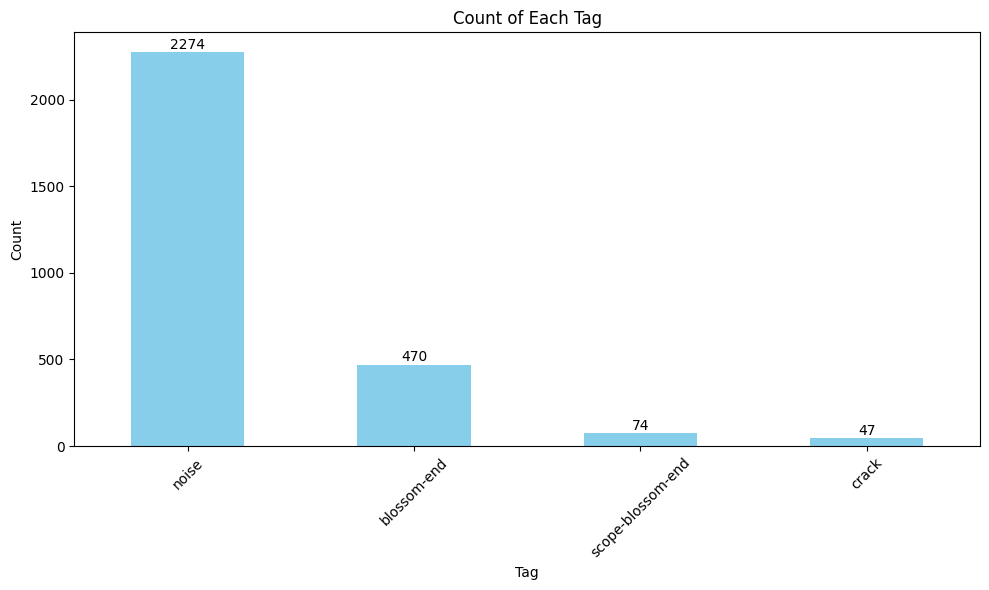

In [ ]:
# Group by 'tag' and count occurrences
tag_counts = df['tag'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
bars = tag_counts.plot(kind='bar', color='skyblue')
plt.title("Count of Each Tag")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add the count value on top of each bar
for i, count in enumerate(tag_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

XGBoost + class wheights

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
le = LabelEncoder()
df['tag_encoded'] = le.fit_transform(df['tag'])  # Add a new column with numeric labels

# Prepare the data: Drop non-numeric columns
X = df.drop(columns=['tag', 'tag_encoded', 'id'])  # Drop 'id' as it's non-numeric
y = df['tag_encoded']                             # Encoded target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights (inverse of class frequencies)
class_counts = y_train.value_counts()
class_weights = {cls: len(y_train) / count for cls, count in class_counts.items()}
print("Class Weights:", class_weights)

# Use the ratio between the majority and minority classes
scale_pos_weight = class_weights[2] / class_weights[1]  # Adjust for imbalance
print("Scale Pos Weight:", scale_pos_weight)

# Initialize and train the XGBoost classifier
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,
                          use_label_encoder=False,
                          eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))  # Map back to original names
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Class Weights: {2: 1.2600329851566794, 0: 6.095744680851064, 3: 38.847457627118644, 1: 60.31578947368421}
Scale Pos Weight: 0.020890599230346342


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                   precision    recall  f1-score   support

      blossom-end       0.73      0.74      0.74        94
            crack       0.50      0.22      0.31         9
            noise       0.93      0.95      0.94       455
scope-blossom-end       1.00      0.60      0.75        15

         accuracy                           0.89       573
        macro avg       0.79      0.63      0.68       573
     weighted avg       0.89      0.89      0.89       573

Confusion Matrix:
[[ 70   1  23   0]
 [  0   2   7   0]
 [ 24   1 430   0]
 [  2   0   4   9]]


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE Class Distribution:")
print(pd.Series(y_train_smote).value_counts())


After SMOTE Class Distribution:
tag_encoded
2    1819
0    1819
3    1819
1    1819
Name: count, dtype: int64


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions on the original test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))  # Map back to original class names

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:52:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                   precision    recall  f1-score   support

      blossom-end       0.69      0.81      0.75        94
            crack       0.40      0.44      0.42         9
            noise       0.95      0.92      0.93       455
scope-blossom-end       1.00      0.80      0.89        15

         accuracy                           0.89       573
        macro avg       0.76      0.74      0.75       573
     weighted avg       0.90      0.89      0.89       573

Confusion Matrix:
[[ 76   1  17   0]
 [  0   4   5   0]
 [ 32   5 418   0]
 [  2   0   1  12]]


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import numpy as np
import pandas as pd

# Initialize Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Create placeholders for results
confusion_matrices = []
f1_scores = []

# Loop through each fold manually
for fold, (train_index, test_index) in enumerate(skf.split(X_train_smote, y_train_smote)):
    print(f"\nFold {fold + 1}")

    # Split data into train and test for this fold
    X_train_fold, X_test_fold = X_train_smote.iloc[train_index], X_train_smote.iloc[test_index]
    y_train_fold, y_test_fold = y_train_smote.iloc[train_index], y_train_smote.iloc[test_index]

    # Train the XGBoost model
    model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred = model.predict(X_test_fold)

    # Compute confusion matrix and F1-score
    cm = confusion_matrix(y_test_fold, y_pred)
    report = classification_report(y_test_fold, y_pred)

    # Save results
    confusion_matrices.append(cm)
    f1_scores.append(np.mean(cross_val_score(model, X_test_fold, y_test_fold, cv=skf, scoring='f1_weighted')))

    # Display results for this fold
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

# Print the average results
print("\n--- Overall Results ---")
print(f"Mean F1 Score Across Folds: {np.mean(f1_scores):.4f}")
print(f"Standard Deviation of F1 Scores: {np.std(f1_scores):.4f}")



Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Confusion Matrix:
[[354   1   9   0]
 [  0 364   0   0]
 [ 16   4 343   1]
 [  0   0   0 364]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       364
           1       0.99      1.00      0.99       364
           2       0.97      0.94      0.96       364
           3       1.00      1.00      1.00       364

    accuracy                           0.98      1456
   macro avg       0.98      0.98      0.98      1456
weighted avg       0.98      0.98      0.98      1456


Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Confusion Matrix:
[[343   3  18   0]
 [  1 362   0   0]
 [ 21  11 328   4]
 [  0   0   0 364]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       364
           1       0.96      1.00      0.98       363
           2       0.95      0.90      0.92       364
           3       0.99      1.00      0.99       364

    accuracy                           0.96      1455
   macro avg       0.96      0.96      0.96      1455
weighted avg       0.96      0.96      0.96      1455


Fold 3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Confusion Matrix:
[[359   2   3   0]
 [  0 363   1   0]
 [ 21   4 335   4]
 [  0   0   0 363]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       364
           1       0.98      1.00      0.99       364
           2       0.99      0.92      0.95       364
           3       0.99      1.00      0.99       363

    accuracy                           0.98      1455
   macro avg       0.98      0.98      0.98      1455
weighted avg       0.98      0.98      0.98      1455


Fold 4


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Confusion Matrix:
[[349   3  11   0]
 [  0 364   0   0]
 [ 24   4 334   2]
 [  0   0   0 364]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       363
           1       0.98      1.00      0.99       364
           2       0.97      0.92      0.94       364
           3       0.99      1.00      1.00       364

    accuracy                           0.97      1455
   macro avg       0.97      0.97      0.97      1455
weighted avg       0.97      0.97      0.97      1455


Fold 5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:14:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Confusion Matrix:
[[358   1   5   0]
 [  0 364   0   0]
 [ 19   5 338   1]
 [  0   0   0 364]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       364
           1       0.98      1.00      0.99       364
           2       0.99      0.93      0.96       363
           3       1.00      1.00      1.00       364

    accuracy                           0.98      1455
   macro avg       0.98      0.98      0.98      1455
weighted avg       0.98      0.98      0.98      1455


--- Overall Results ---
Mean F1 Score Across Folds: 0.9446
Standard Deviation of F1 Scores: 0.0039


# Run classifier based on paper : A Convolutional Neural Network approach for image-based anomaly detection in smart agriculture

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os

# Define batch size
batch_size = 32

# Load the annotations
data_path = '/content/gdrive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB/anomaly_original_size_4'
annotations_path = '/content/gdrive/Othercomputers/My PC/Thesis/SAM Annotations CSV/2023/segment_details_y.csv'
annotations = pd.read_csv(annotations_path)
annotations['filename'] = annotations['id'].apply(lambda x: os.path.join(data_path, f"{x}.JPG"))

# Encode class values as integers
encoder = LabelEncoder()
annotations['tag_encoded'] = encoder.fit_transform(annotations['tag'])

# Split data into training and validation sets
train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, random_state=42)

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(loc=0.0, scale=0.05, size=x.shape)  # Gaussian noise
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generator function to yield batches of data
def generate_data(annotations_df, datagen):
    while True:
        for start in range(0, len(annotations_df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(annotations_df))
            df_batch = annotations_df[start:end]
            for _, row in df_batch.iterrows():
                img = tf.keras.preprocessing.image.load_img(row['filename'], target_size=(224, 224))
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = datagen.random_transform(img)
                x_batch.append(img)
                y_batch.append(row['tag_encoded'])
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = to_categorical(y_batch, num_classes=len(encoder.classes_))
            yield x_batch, y_batch

# Initialize and train models
models = {
    'VGG16': create_model(VGG16),
    'InceptionV3': create_model(InceptionV3),
    'ResNet50': create_model(ResNet50),
    'Xception': create_model(Xception)
}


Training VGG16
71/71 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6944 - loss: 0.8088 - val_accuracy: 0.7592 - val_loss: 0.5550
Training InceptionV3
71/71 ━━━━━━━━━━━━━━━━━━━━ 123s 662ms/step - accuracy: 0.8022 - loss: 0.5799 - val_accuracy: 0.9026 - val_loss: 0.5201
Training ResNet50
71/71 ━━━━━━━━━━━━━━━━━━━━ 103s 640ms/step - accuracy: 0.8282 - loss: 0.4623 - val_accuracy: 0.7849 - val_loss: 1.6776
Training Xception
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 626ms/step - accuracy: 0.7498 - loss: 0.7258 - val_accuracy: 0.9154 - val_loss: 0.2879


Training VGG16
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 605ms/step - accuracy: 0.8898 - loss: 0.3061 - val_accuracy: 0.8805 - val_loss: 0.3290
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 720ms/step - accuracy: 0.8868 - loss: 0.3169 - val_accuracy: 0.9353 - val_loss: 0.2410
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 572ms/step - accuracy: 0.9136 - loss: 0.2554 - val_accuracy: 0.9445 - val_loss: 0.2079
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 560ms/step - accuracy: 0.9306 - loss: 0.2156 - val_accuracy: 0.9445 - val_loss: 0.1978
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 560ms/step - accuracy: 0.9360 - loss: 0.1924 - val_accuracy: 0.9427 - val_loss: 0.1841
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 567ms/step - accuracy: 0.9489 - loss: 0.1677 - val_accuracy: 0.9390 - val_loss: 0.1932
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 572ms/step - accuracy: 0.9380 - loss: 0.1884 - val_accuracy: 0.9445 - val_loss: 0.1956
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 560ms/step - accuracy: 0.9494 - loss: 0.

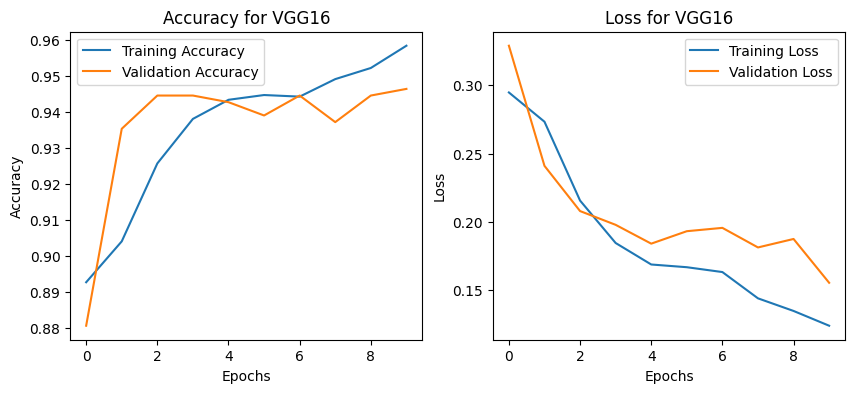

Training InceptionV3
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 597ms/step - accuracy: 0.9328 - loss: 0.1859 - val_accuracy: 0.9246 - val_loss: 0.2869
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 89s 674ms/step - accuracy: 0.9509 - loss: 0.1619 - val_accuracy: 0.9409 - val_loss: 0.2150
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 552ms/step - accuracy: 0.9681 - loss: 0.0971 - val_accuracy: 0.9427 - val_loss: 0.2128
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 551ms/step - accuracy: 0.9691 - loss: 0.0916 - val_accuracy: 0.9445 - val_loss: 0.2091
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 525ms/step - accuracy: 0.9723 - loss: 0.0724 - val_accuracy: 0.9501 - val_loss: 0.1620


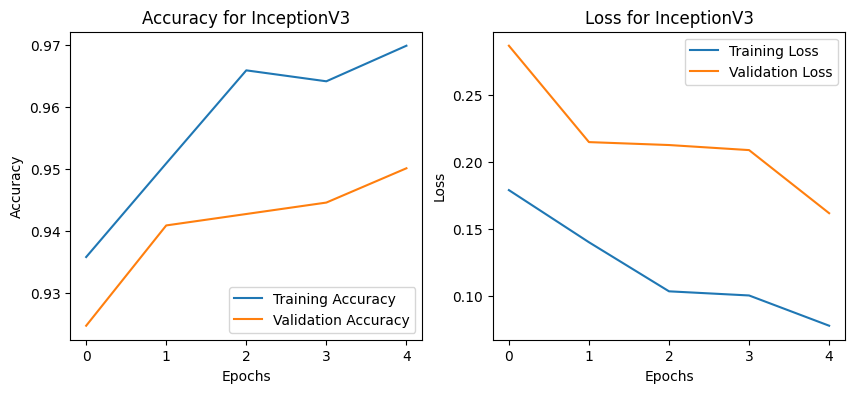

Training ResNet50
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 605ms/step - accuracy: 0.9366 - loss: 0.1890 - val_accuracy: 0.7849 - val_loss: 1.2176
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 613ms/step - accuracy: 0.9494 - loss: 0.1521 - val_accuracy: 0.7856 - val_loss: 1.1023
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - accuracy: 0.9512 - loss: 0.1409 - val_accuracy: 0.7837 - val_loss: 1.2304
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 538ms/step - accuracy: 0.9638 - loss: 0.1146 - val_accuracy: 0.7837 - val_loss: 0.8634
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 540ms/step - accuracy: 0.9711 - loss: 0.0824 - val_accuracy: 0.7874 - val_loss: 1.6686


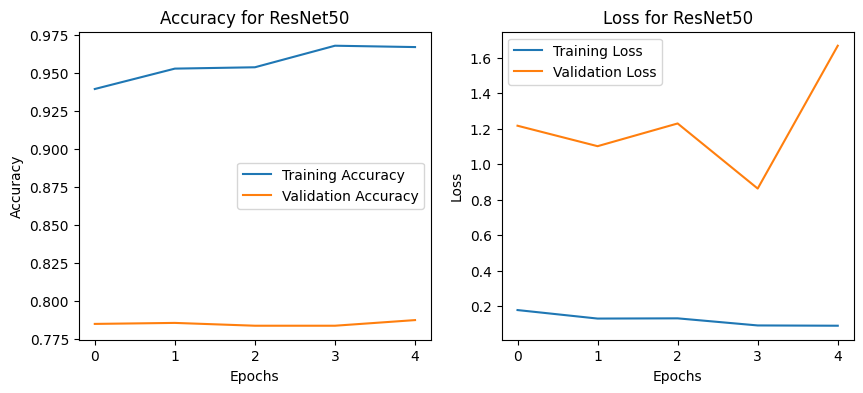

Training Xception
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 582ms/step - accuracy: 0.9352 - loss: 0.1786 - val_accuracy: 0.9412 - val_loss: 0.1683
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 659ms/step - accuracy: 0.9565 - loss: 0.1338 - val_accuracy: 0.9464 - val_loss: 0.1285
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - accuracy: 0.9700 - loss: 0.1007 - val_accuracy: 0.9482 - val_loss: 0.1418
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 538ms/step - accuracy: 0.9679 - loss: 0.0982 - val_accuracy: 0.9538 - val_loss: 0.1165
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 541ms/step - accuracy: 0.9786 - loss: 0.0663 - val_accuracy: 0.9630 - val_loss: 0.1041
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 541ms/step - accuracy: 0.9829 - loss: 0.0437 - val_accuracy: 0.9593 - val_loss: 0.1507
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.9797 - loss: 0.0527 - val_accuracy: 0.9556 - val_loss: 0.1311
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 550ms/step - accuracy: 0.9828 - loss:

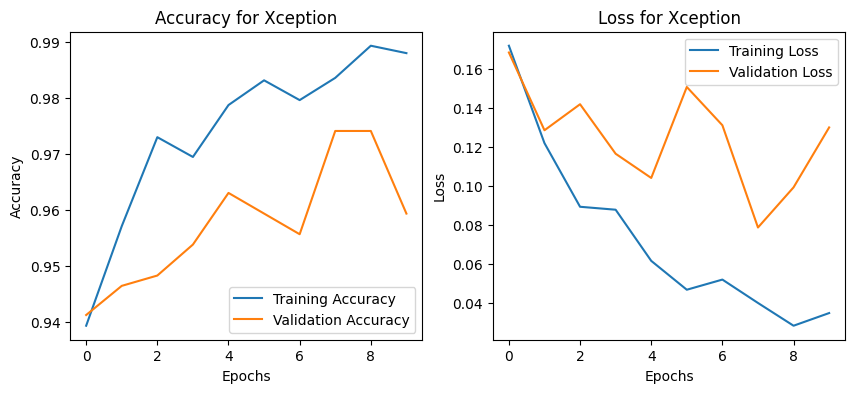

In [ ]:
for name, model in models.items():
    print(f"Training {name}")
    history = model.fit(
        generate_data(train_annotations, train_datagen),
        steps_per_epoch=len(train_annotations) // batch_size,
        epochs=10,  # Increased number of epochs
        validation_data=generate_data(val_annotations, val_datagen),
        validation_steps=len(val_annotations) // batch_size,
        callbacks=[early_stop]
    )
    history_dict[name] = history

    # Save the trained model
    model.save(f'{name}_model.h5')

    # Plot training and validation accuracy and loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


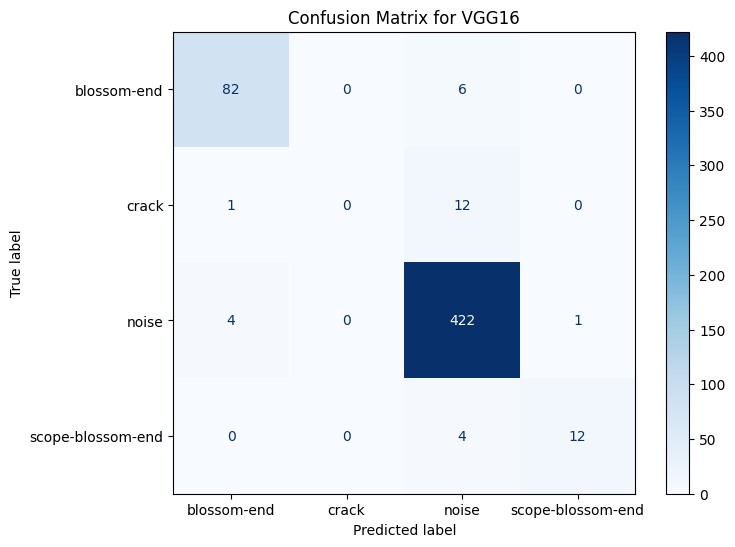

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_generator, steps, class_indices, model_name):
    # Generate predictions and true labels
    y_pred = []
    y_true = []
    for _ in range(steps):
        x, y = next(data_generator)
        preds = model.predict(x)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y, axis=1))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_indices))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title(f"Confusion Matrix for {model_name}")
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


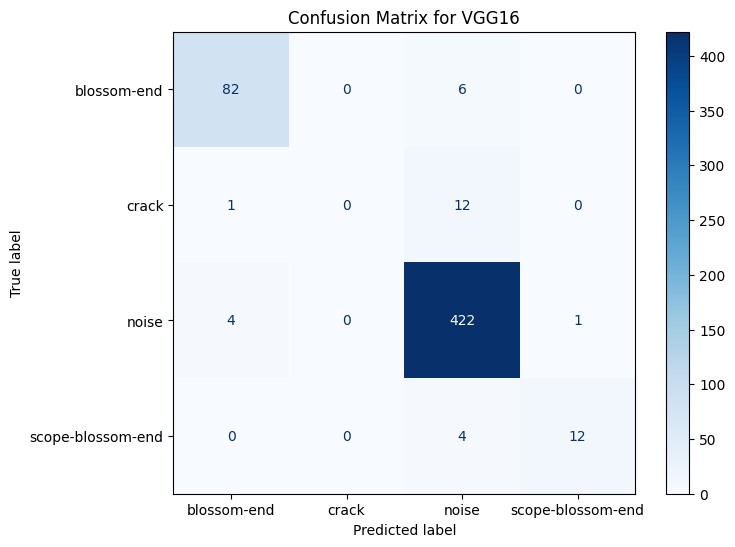

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


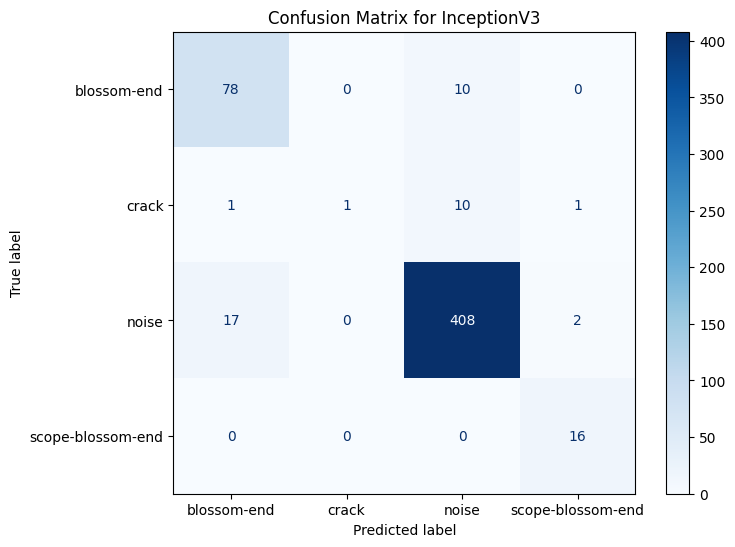

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


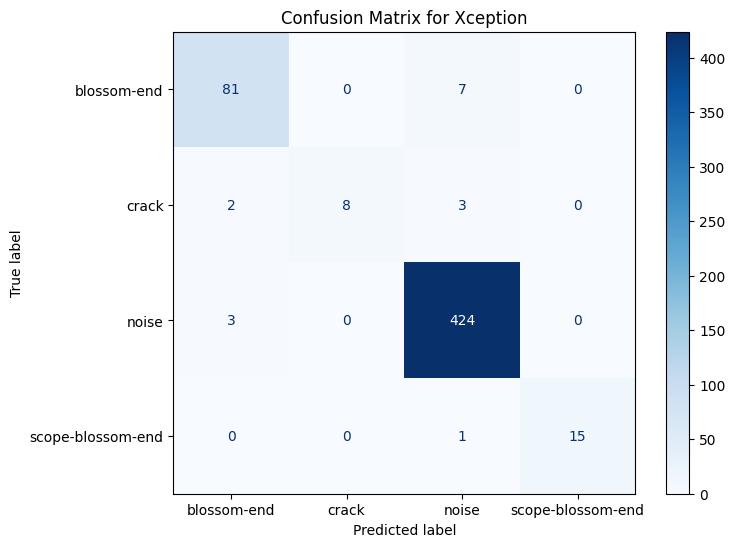

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


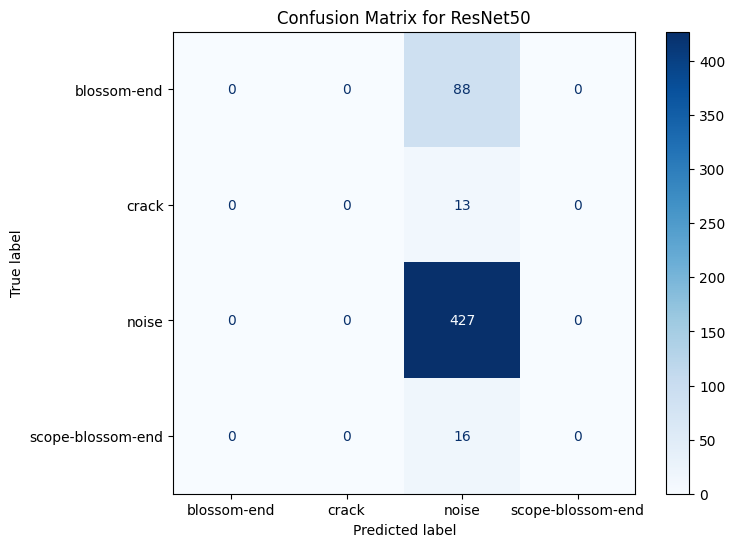

In [ ]:
plot_confusion_matrix(models['VGG16'], generate_data(val_annotations, val_datagen),
                      len(val_annotations) // batch_size, encoder.classes_, model_name='VGG16')

plot_confusion_matrix(models['InceptionV3'], generate_data(val_annotations, val_datagen),
                      len(val_annotations) // batch_size, encoder.classes_, model_name='InceptionV3')

plot_confusion_matrix(models['Xception'], generate_data(val_annotations, val_datagen),
                      len(val_annotations) // batch_size, encoder.classes_, model_name='Xception')

plot_confusion_matrix(models['ResNet50'], generate_data(val_annotations, val_datagen),
                      len(val_annotations) // batch_size, encoder.classes_, model_name='ResNet50')





Evaluating VGG16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


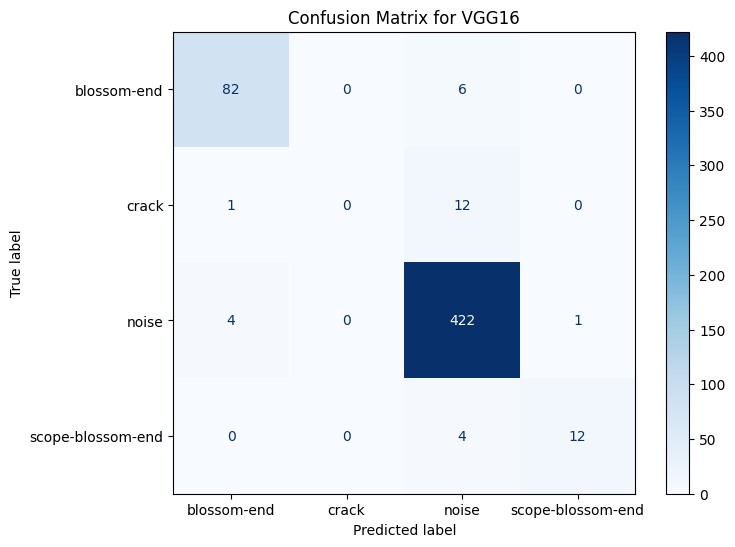

Evaluating InceptionV3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


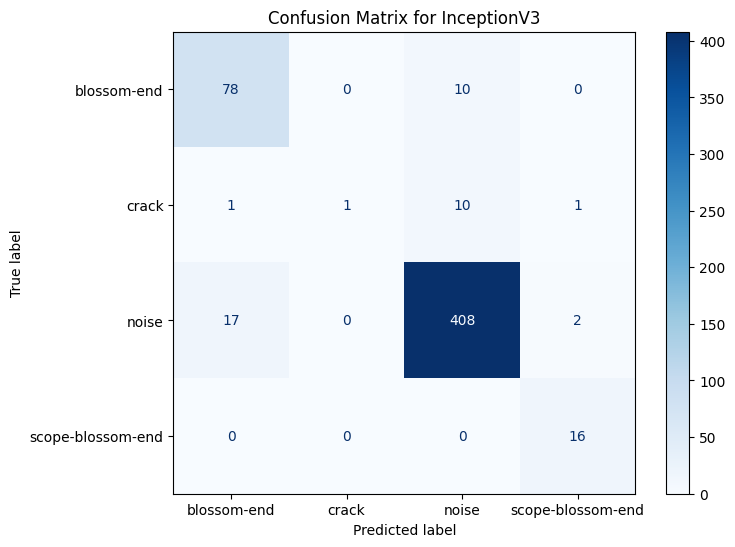

Evaluating ResNet50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


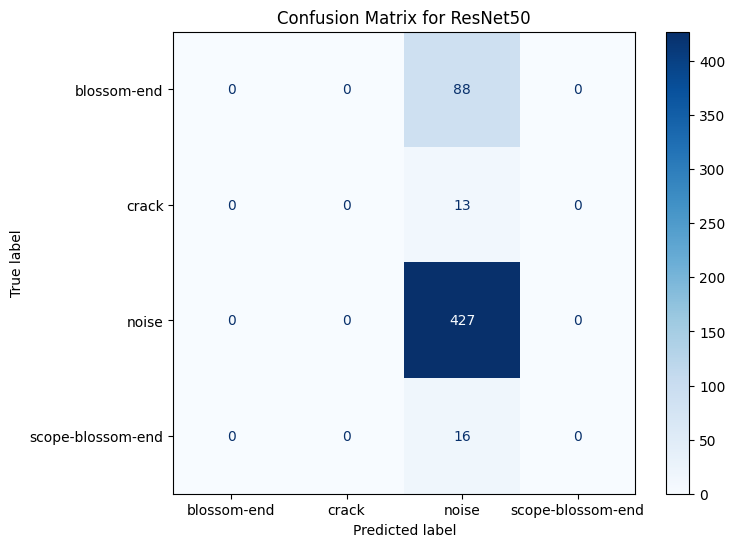

Evaluating Xception
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


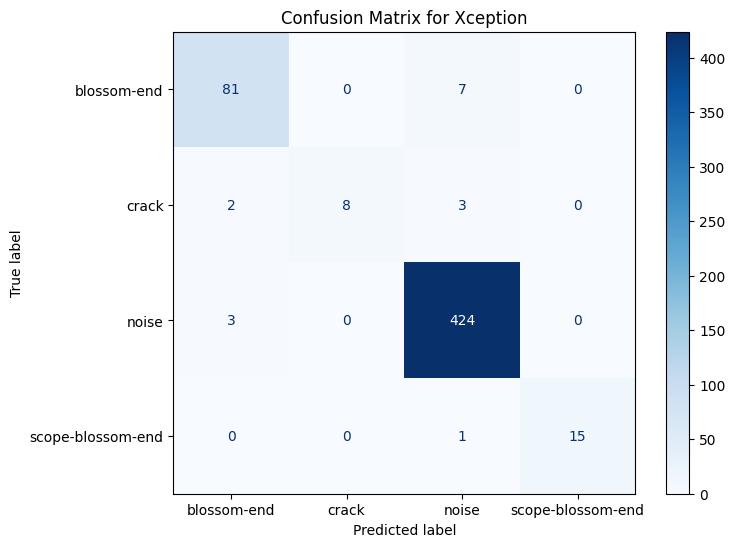

Model Performance Summary:
         Model  Validation Accuracy  Validation Loss
0        VGG16             0.948529         0.147422
1  InceptionV3             0.924632         0.286921
2     ResNet50             0.784926         1.217594
3     Xception             0.970588         0.081143


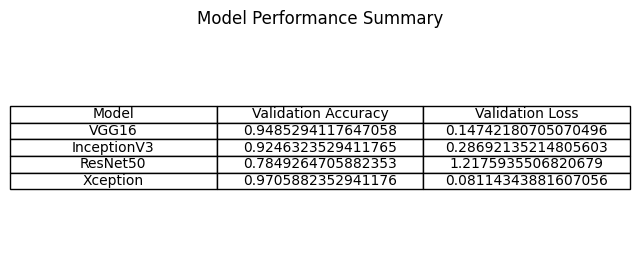

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to plot confusion matrix and collect metrics
def evaluate_model(model, data_generator, steps, class_indices, model_name):
    y_pred = []
    y_true = []
    for _ in range(steps):
        x, y = next(data_generator)
        preds = model.predict(x)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y, axis=1))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_indices))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices)
    plt.figure(figsize=(8, 6))
    plt.title(f"Confusion Matrix for {model_name}")
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.show()

    # Calculate accuracy
    accuracy = (sum(y_true[i] == y_pred[i] for i in range(len(y_true)))) / len(y_true)
    return accuracy

# Collect results
results = []

for name, model in models.items():
    print(f"Evaluating {name}")
    # Get accuracy and validation loss
    accuracy = evaluate_model(model, generate_data(val_annotations, val_datagen), len(val_annotations) // batch_size, encoder.classes_, name)
    val_loss = model.evaluate(generate_data(val_annotations, val_datagen), steps=len(val_annotations) // batch_size, verbose=0)[0]
    results.append({'Model': name, 'Validation Accuracy': accuracy, 'Validation Loss': val_loss})

# Summarize results in a table
results_df = pd.DataFrame(results)
print("Model Performance Summary:")
print(results_df)

# Display results as a table
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Model Performance Summary")
plt.show()


classify new data

In [ ]:
def classify_new_data(models, new_data_path):
    new_data = os.listdir(new_data_path)
    results = {'id': new_data}

    for name, model in models.items():
        predictions = []
        for file_name in new_data:
            img_path = os.path.join(new_data_path, file_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            pred = model.predict(img_array)
            predicted_class = encoder.inverse_transform([np.argmax(pred)])
            predictions.append(predicted_class[0])
        results[name] = predictions

    return pd.DataFrame(results)

# Assuming you have a path for new images
new_data_path = '/path_to_new_data'
classification_results = classify_new_data(models, new_data_path)
print(classification_results)
